<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/7_higgs_boson_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 09/10/2020
Ref:
 1. https://dataplatform.ibm.com/analytics/notebooks/20c1c2d6-6a51-4bdc-9b2c-0e3f2bef7376/view?access_token=52b727bd6515bd687cfd88f929cc7869b0ea420e668b2730c6870e72e029f0d1
 2. http://krasserm.github.io/2018/03/21/bayesian-optimization/

Objectives:
    1. Reading from hard-disk random samples of big-data
    2. Using PCA
    3. Pipelining with StandardScaler, PCA and xgboost
    4. Grid tuning of PCA and xgboost--Avoid data leakage
    5. Randomized search of parameters
    6. Bayes optimization
    7. Feature importance
    8. Genetic algorithm for tuning of parameters
    9. Find feature importance of any Black box estimator
       using eli5 API


# IMPT NOTE:
# For a complete example that uses both Pipelining and ColumnTransformer
# Please see this website: http://dalex.drwhy.ai/python-dalex-titanic.html
#  And also Folder 24. Pipelining with columntransformer. See also:
#   https://github.com/ModelOriented/DALEX



"""

In [ ]:
# 0.0
! pip install scikit-optimize
! pip install 'scikit-optimize[plots]'

## About L1 and L2 regularization

Regularization can be understood as a technique to improve the generalizability of a learned model.  A simpler model may underfit and will perform poorly with predictions. Just because two data points fit a line perfectly doesn’t mean that a third point will fall exactly on that line — in fact, it’s highly unlikely. One needs to move from simpler model to complex model to improve upon predictions. It is here that regularization helps by stopping us on the way and not allowing the model to be over-complex as to overfit the model.  

Simply put, regularization penalizes models that are more complex in favor of simpler models (ones with smaller regression coefficients) — but not at the expense of reducing predictive power.

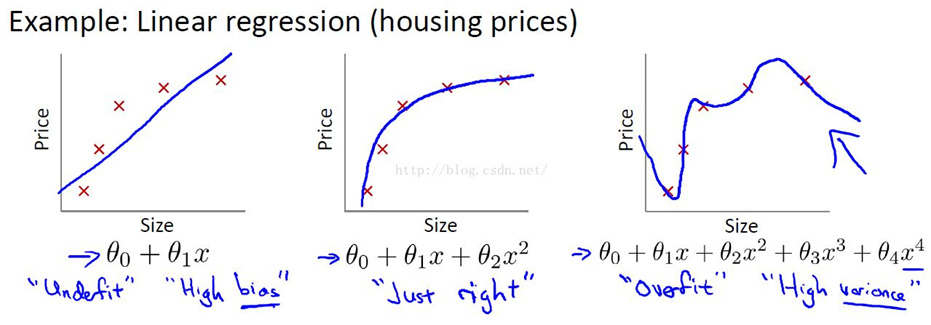

### Penalty terms

Regularization works by biasing data towards particular values (such as small values near zero). The bias is achieved by adding a tuning parameter to encourage those values:

> L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.

> L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). Ridge regression and SVMs use this method.

> Elastic nets combine L1 & L2 methods, but does add a second hyperparameter.


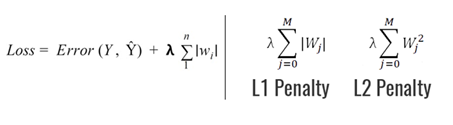

#### Elastic net

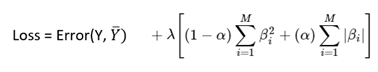

### Regularization how it works

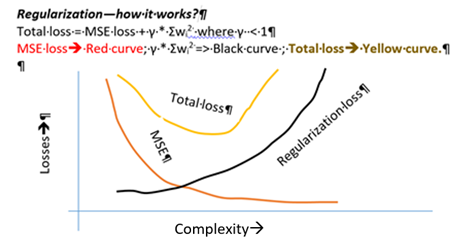

## Call libraries

In [ ]:
# 1.0 Clear ipython memory
#%reset -f

# 1.1 Data manipulation and plotting modules
import numpy as np
import pandas as pd


# 1.2 Data pre-processing
#     z = (x-mean)/stdev
from sklearn.preprocessing import StandardScaler as ss

# 1.3 Dimensionality reduction
from sklearn.decomposition import PCA

# 1.4 Data splitting and model parameter search
from sklearn.model_selection import train_test_split

# 1.6 Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 1.5 Modeling modules
#     Call sklearn wrapper of xgboost
# """Scikit-Learn Wrapper interface for XGBoost."""
#  """Implementation of the Scikit-Learn API for XGBoost.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# Stackoverflow:
# https://stackoverflow.com/a/34696477
# https://stackoverflow.com/a/46947191
# Install as: conda install -c anaconda py-xgboost
from xgboost.sklearn import XGBClassifier

In [ ]:
# 1.7 Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

# 1.8
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# 1.10 Install as: pip install bayesian-optimization
#     Refer: https://github.com/fmfn/BayesianOptimization
#     conda install -c conda-forge bayesian-optimization
#from bayes_opt import BayesianOptimization

# 1.10 Install skopt as:
#     pip install scikit-optimize
#     pip install 'scikit-optimize[plots]'
#     Refer: https://github.com/scikit-optimize/scikit-optimize
#     conda install -c conda-forge scikit-optimize
#from bayes_opt import BayesianOptimization

In [ ]:
# 1.11 Find feature importance of ANY BLACK BOX estimator
#      See note at the end of this code for explanation
#      Refer: https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html
#      Install as:
#      conda install -c conda-forge eli5
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
# 1.12 Misc
import time
import os
import gc
import random
# 1.12.1 Used in Randomized parameter search
from scipy.stats import uniform



In [ ]:
# 3.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# 1.13 Set option to dislay many rows
pd.set_option('display.max_columns', 100)

In [ ]:
from google.colab import drive
# Path where to mount MyDrive
# We will mount it at /ashok
# This drive will be created
drive.mount('/ashok')


Mounted at /ashok


In [ ]:
path = "/ashok/MyDrive/Colab_data_files/bnp_paribas/"


In [ ]:
################# BB. Read data randomly #################
# 2.0 Read random chunks of 10% of data


# 2.1 Set working directory
#os.chdir("C:\\Users\\ashok\\OneDrive\\Documents\\higgsBoson")
#os.chdir("D:\\data\\OneDrive\\Documents\\higgsBoson")
#path = "/home/ashok/Documents/10.higgsBoson"
#path="C:\\Users\\ashok\\Desktop\\cbi\\10.higgsBoson"
os.chdir(path)
os.listdir()


# 2.2 Count number of lines in the file
#     Data has 250001 rows including header also
tr_f = "training.csv.zip"


# 2.3 Total number of lines
#     But we will read 40% of data randomly
total_lines = 250000
num_lines = 0.4 * total_lines    # 40% of data


# 2.4 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = num_lines/total_lines  # fraction of lines to read (40%)

# 2.4.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header

data = pd.read_csv(
         tr_f,
         header=0,   # First row is header-row
         # 'and' operator returns True if both values are True
         #  random.random() returns values between (0,1)
         #  No of rows skipped will be around 60% of total
         skiprows=lambda i: (i >0 ) and (random.random() > p)    # (i>0) implies skip first header row
         )



['training.csv.zip']

In [ ]:
# 3.0 Explore data
print("\n Shape")
data.shape                # 100039, 33)
print("\n Columns")
data.columns.values       # Label column is the last one
print("\n")
# 3.1

print("\nTarget distribution")
data.Label.value_counts()  # Classes are not unbalanced
                           # Binary data
                           #  b: 65558 , s: 34242
print("\n\nData types")                        
data.dtypes.value_counts()  # Label column is of object type
print("\n")
data.head(3)


 Shape


(99819, 33)


 Columns


array(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt', 'Weight', 'Label'], dtype=object)




Target distribution


b    65644
s    34175
Name: Label, dtype: int64



Data types


float64    30
int64       2
object      1
dtype: int64

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100001,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226,2.233584,b
1,100002,-999.000,162.172,125.953,35.635,-999.0,-999.0,-999.0,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.0,-999.0,-999.0,44.251,2.347389,b
2,100008,105.594,50.559,100.989,4.288,-999.0,-999.0,-999.0,2.904,4.288,65.333,0.675,-1.366,-999.0,39.008,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000,5.296003,b


In [ ]:
data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000,99819.000000
mean,225150.884090,-50.875064,49.337020,81.023619,57.729988,-709.238770,-601.776277,-710.176522,2.371573,18.883925,158.081432,1.434385,-0.133554,-709.802428,38.745051,-0.009253,-0.013099,46.583604,-0.018418,0.047349,41.732677,-0.015998,209.447740,0.975355,-350.260291,-401.059393,-401.069475,-693.247287,-709.936970,-709.932552,72.752778,1.649310
std,72078.300875,407.865557,35.419458,40.621057,63.691603,454.104261,659.091060,452.637801,0.781288,23.311146,115.298808,0.840235,1.193023,453.219998,22.571582,1.214181,1.816504,22.055521,1.266124,1.818102,33.361397,1.814719,125.950109,0.976006,533.364310,489.703792,489.695591,479.471576,453.010413,453.017069,97.557946,1.873259
min,100001.000000,-999.000000,0.000000,7.120000,0.000000,-999.000000,-999.000000,-999.000000,0.224000,0.000000,46.227000,0.074000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.490000,-3.142000,0.162000,-3.142000,21.066000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162877.000000,77.755500,19.263000,59.373000,13.878500,-999.000000,-999.000000,-999.000000,1.809000,2.842000,77.332500,0.881000,-1.372000,-999.000000,24.625000,-0.924000,-1.582000,32.343000,-1.010000,-1.525000,21.440500,-1.587000,122.795500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,225231.000000,104.775000,46.705000,73.667000,38.214000,-999.000000,-999.000000,-999.000000,2.493000,12.210000,120.036000,1.278000,-0.369000,-999.000000,31.830000,-0.023000,-0.041000,40.406000,-0.049000,0.094000,34.854000,-0.024000,179.521000,1.000000,38.740000,-1.894000,-2.123000,-999.000000,-999.000000,-999.000000,40.195000,1.166067
75%,287581.500000,130.416500,73.682500,92.075000,79.095500,0.486000,82.530000,-4.670000,2.960000,27.516500,199.975000,1.774000,1.220000,0.000000,45.058000,0.901000,1.561000,53.216000,0.961000,1.625000,51.933500,1.556000,262.826500,2.000000,75.234500,0.424000,0.473500,33.657000,-2.476000,-2.275000,109.728000,2.405520
max,349998.000000,988.199000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1513.470000,18.992000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.496000,3.141000,2842.617000,3.141000,1603.963000,3.000000,683.198000,4.492000,3.141000,499.032000,4.492000,3.142000,1390.350000,7.817383


In [ ]:
# 3.2 We do not need Id column and Weight column
data.drop(columns = ['EventId','Weight'],inplace = True  )



In [ ]:

# 3.3 Divide data into predictors and target
#     First 30 columns are predictors
X = data.iloc[ :, 0:30]
X.head(2)
# 3.3.1 30th index or 31st column is target
print("\n\nTarget,y, values")
y = data.iloc[ : , 30]
y.head()


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226
1,-999.000,162.172,125.953,35.635,-999.0,-999.0,-999.0,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.0,-999.0,-999.0,44.251




Target,y, values


0    b
1    b
2    b
3    b
4    s
Name: Label, dtype: object

In [ ]:
# 3.3.2 Can we change datatype to float32 ?
X.min().min()           # -999.0
X.max().max()           # 4543.913

# 3.3.3  Save memory
X = X.astype('float32')


-999.0

4974.979

In [ ]:
# 3.4 Transform label data to '1' and '0'
#    'map' works element-wise on a Series.
y = y.map({'b':1, 's' : 0})
y.dtype           # int64


# 3.5 Store column names somewhere
#     for use in feature importance

colnames = X.columns.tolist()


dtype('int64')

In [ ]:

# 4. Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    shuffle = True,
                                                    stratify = y
                                                    )

# 4.1
X_train.shape        # (65025, 30)
X_test.shape         # (35014, 30)
y_train.shape        # (65025,)
y_test.shape         # (35014,)



(64882, 30)

(34937, 30)

(64882,)

(34937,)

## Cross Validation

### Part picture

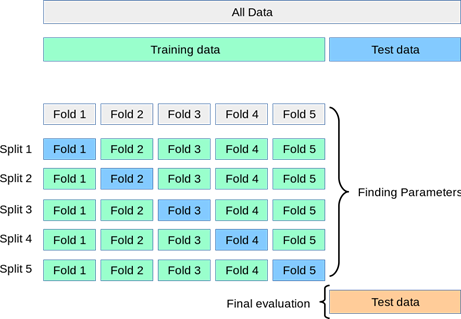

### Full picture

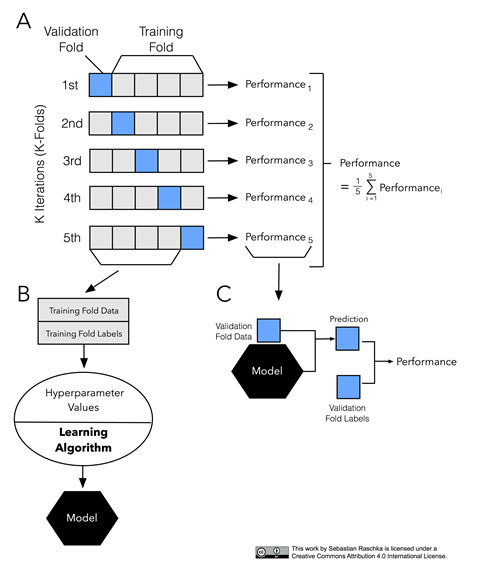

## Grid Search vs Random Search
See this [link](https://stats.stackexchange.com/a/209409) and this [link](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35).

Green curves show true objective function as a function of the given parameter. While Grid search misses the Objective function completely, Random Search does not. (We are assuming here that one parameter is important and the other not. So the Objective function depends completely on the values of one parameter.) 

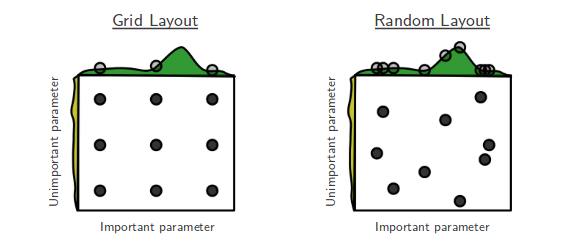

Random search can still miss the global optimum completely, as in the following illustration.

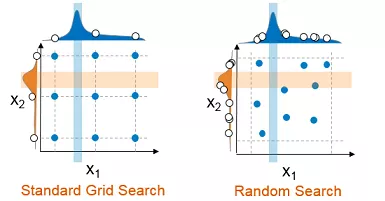

Intuitively, both for Grid Search as also for Random Search, it would be more efficient to choose the next hyperparameter combination according to past combinations performances. A mutual drawback of both these approaches is that the method loses efficiency if the understanding or importance of model parameters are not known beforehand. That is, we start tuning both important as also unimportant parameters thus wasting computer resources. 

In [ ]:
################# CC. Create pipeline #################
#### Pipe using XGBoost


# 5 Pipeline steps
# steps: List of (name, transform) tuples
#       (implementing fit/transform) that are
#       chained, in the order in which they
#       are chained, with the last object an
#       estimator.
#      Format: [(name, transformer), (name, transformer)..(name, estimator)]
steps_xg = [('sts', ss() ),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=3)        # Specify other parameters here
            )
            ]

# 5.1  Instantiate Pipeline object
pipe_xg = Pipeline(steps_xg)

# 5.2 Another way to create pipeline:
#     Not used below
#pipe_xg1 = make_pipeline (
#                          ss(),
#                          PCA(),
#                          XGBClassifier(silent = False,
#                                        n_jobs=2)
#                          )



In [ ]:

##################$$$$$$$$$$$#####################
## Jump now to
##   Either:   Grid Search (DD)             para 6
##       Or:   Random Search (EE)
##       Or:   Bayesian Optimization (GG)
##       Or:   Evolutionary Algorithm (HH)
##################$$$$$$$$$$$#####################

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
##################### DD. Grid Search #################

# 6.  Specify xgboost parameter-range
# 6.1 Dictionary of parameters (16 combinations)
#     Syntax: {
#              'transformerName__parameterName' : [ <listOfValues> ]
#              }
#
# 6.2 What parameters in the pipe are available for tuning
pipe_xg.get_params()


{'memory': None,
 'pca': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'steps': [('sts', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0,
                 learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100, n_jobs=3,
                 nthread=None, objective='binary:logistic', random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               

In [ ]:

# 6.3
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              #'xg__n_estimators':   [200,  300],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers

              #'xg__max_depth':      [4,6],
              'pca__n_components' : [25,30],
              'xg__booster': ['gbtree','gblinear']
              }                               # Total: 2 * 2 * 2 * 2



In [ ]:

# 7  Grid Search (16 * 2) iterations
#    Create Grid Search object first with all necessary
#    specifications. Note that data, X, as yet is not specified

#    Data Leakage and pipelining:
#    Pipeline avoids data leakage during GridSearch
#    See this: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 2,         # USe parallel cpu threads
                   cv =2 ,             # No of folds
                   verbose =1,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                   )

## 7.1 Delete objects not needed
#      We need X_train, y_train, X_test, y_test
del X
del data
del y
gc.collect()


NameError: ignored

In [ ]:
######
#### @@@@@@@@@@@@@@@@@@@ #################
## REBOOT lubuntu MACHINE HERE
#### @@@@ AND NOW WORK IN sublime @@@@@#####


# 7.2. Start fitting data to pipeline
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60               # 25 minutes

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:  1.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sts',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('xg',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                 

1.2405535062154134

In [ ]:
# 7.3
f"Best score: {clf.best_score_} "            # 'Best score: 0.8804992694908675 '
f"Best parameter set {clf.best_params_}"


'Best score: 0.8498269175616353 '

"Best parameter set {'pca__n_components': 30, 'xg__booster': 'gbtree', 'xg__learning_rate': 0.05}"

array([0, 1, 1, ..., 1, 1, 0])

'Accuracy: 78.28663022011048'

array([[ 7094,  4867],
       [ 2719, 20257]])

0.8422869022869024

0.6516028290621844

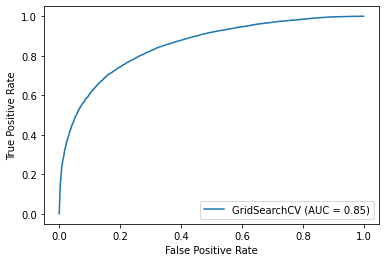

In [ ]:
# 7.4. Make predictions using the best returned model
y_pred = clf.predict(X_test)
y_pred

# 7.5 Accuracy
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"             # 'Accuracy: 82.11165535218126'

# 7.6 Confusion matrix
confusion_matrix( y_test,y_pred)

# 7.7 F1 score
f1_score(y_test,y_pred, pos_label = 1)      # 0.8664199696263183
f1_score(y_test,y_pred, pos_label = 0)      # 0.729313857223354

# 7.8 ROC curve
plot_roc_curve(clf, X_test, y_test)


In [ ]:
# 7.9 Get feature importances from GridSearchCV best fitted 'xg' model
#     See stackoverflow: https://stackoverflow.com/q/48377296
clf.best_estimator_.named_steps["xg"].feature_importances_
clf.best_estimator_.named_steps["xg"].feature_importances_.shape


array([0.1068259 , 0.02047754, 0.21491355, 0.04315173, 0.07486128,
       0.01940387, 0.        , 0.02970317, 0.        , 0.06240249,
       0.        , 0.04834986, 0.01811613, 0.03008382, 0.03310466,
       0.02021873, 0.06720933, 0.01318368, 0.08140566, 0.07059869,
       0.01620047, 0.00414872, 0.        , 0.00150562, 0.01032812,
       0.00101982, 0.00157627, 0.        , 0.01121084, 0.        ],
      dtype=float32)

(30,)

In [ ]:
# 7.10 Create a dataframe of feature importances
fe_values = clf.best_estimator_.named_steps["xg"].feature_importances_
df_fe = pd.DataFrame(data = fe_values,index = colnames, columns = ["fe"]).sort_values(by = 'fe')
df_fe

In [ ]:
# 7.11 First five columns with least feature importance are:
list(df_fe.index.values[:5])

['PRI_jet_all_pt',
 'PRI_jet_num',
 'PRI_jet_subleading_eta',
 'DER_prodeta_jet_jet',
 'DER_pt_ratio_lep_tau']

In [ ]:
# 7.12 Let us drop these from X_train and X_test
Xtrain = X_train.drop(columns = list(df_fe.index.values[:5]))
Xtest = X_test.drop(columns = list(df_fe.index.values[:5]))

# 7.13 Build model again with reduced dataset
clf_dr = GridSearchCV(pipe_xg,            # pipeline object
                      parameters,         # possible parameters
                      n_jobs = 2,         # USe parallel cpu threads
                      cv =3 ,             # No of folds
                      verbose =2,         # Higher the value, more the verbosity
                      scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                      refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                     )

# 7.14
start = time.time()
clf_dr.fit(Xtrain, y_train)
end = time.time()
(end - start)/60               # 25 minutes

# 7.15 Make predictions
y_pred_dr = clf_dr.predict(Xtest)

# 7.16 Compare results.
#      Results may be marginally better
f1_score(y_test,y_pred_dr, pos_label = 1)      # 0.8664199696263183
f1_score(y_test,y_pred_dr, pos_label = 0)      # 0.729313857223354
f1_score(y_test,y_pred, pos_label = 1)      # 0.8664199696263183
f1_score(y_test,y_pred, pos_label = 0)      # 0.729313857223354
##################################


In [ ]:
##################### EE. Randomized Search #################

# Tune parameters using randomized search
# 8. Hyperparameters to tune and their ranges
parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,300),
              'xg__max_depth':      range(3,10),
              'pca__n_components' : range(20,30)}

In [ ]:

# 8.1 Tune parameters using random search
#     Create the object first
rs = RandomizedSearchCV(pipe_xg,
                        param_distributions=parameters,
                        scoring= ['roc_auc', 'accuracy'],
                        n_iter=4,           # Max combination of
                                            # parameter to try. Default = 10
                        verbose = 1,
                        refit = 'roc_auc',
                        n_jobs = 2,          # Use parallel cpu threads
                        cv = 2               # No of folds.
                                             # So n_iter * cv combinations
                        )


In [ ]:


# 8.2 Run random search for 25 iterations. 21 minutes
start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60   # 3minutes



Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:  2.5min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('sts',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('xg',
                                              XGBClassifier(base_score=0.5,
                              

3.120113678773244

In [ ]:
# 8.3 Evaluate
f"Best score: {rs.best_score_} " ;print()           # 'Best score: 0.8780097831252602 '
f"Best parameter set: {rs.best_params_} " ; print()


# 8.4 Make predictions from the best returned model
y_pred = rs.predict(X_test)


# 8.5 Accuracy and f1_score
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"   ; print()      # 'Accuracy: 82.0142648448913'
f"f1 score: {f1_score(y_test,y_pred, pos_label = 1)}" ; print()     # 0.8655661892221722


'Best score: 0.8794796594895731 '

"Best parameter set: {'pca__n_components': 23, 'xg__learning_rate': 0.21474272507656778, 'xg__max_depth': 5, 'xg__n_estimators': 225} "

'Accuracy: 81.71565961588001'

'f1 score: 0.8637604504350792'

In [ ]:
############### FF. Fitting parameters in our model ##############
###############    Model Importance   #################

# 9. Model with parameters of grid search
model_gs = XGBClassifier(
                    learning_rate = clf.best_params_['xg__learning_rate'],
                    max_depth = clf.best_params_['xg__max_depth'],
                    n_estimators=clf.best_params_['xg__max_depth']
                    )

# 9.1 Model with parameters of random search
model_rs = XGBClassifier(
                    learning_rate = rs.best_params_['xg__learning_rate'],
                    max_depth = rs.best_params_['xg__max_depth'],
                    n_estimators=rs.best_params_['xg__max_depth']
                    )


# 9.2 Modeling with both parameters
start = time.time()
model_gs.fit(X_train, y_train)
model_rs.fit(X_train, y_train)
end = time.time()
(end - start)/60


# 9.3 Predictions with both models
y_pred_gs = model_gs.predict(X_test)
y_pred_rs = model_rs.predict(X_test)


# 9.4 Accuracy from both models
accuracy_gs = accuracy_score(y_test, y_pred_gs)
accuracy_rs = accuracy_score(y_test, y_pred_rs)
accuracy_gs
accuracy_rs


In [ ]:
!pip install PyQt5

     |████████████████████████████████| 8.3MB 4.9MB/s 
     |████████████████████████████████| 59.9MB 68kB/s 
     |████████████████████████████████| 317kB 37.7MB/s 


In [ ]:

import PyQt5
%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )

In [ ]:
# 10.1 Plt now

%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain', 
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.
                            
data


In [ ]:
# 10.1 Plt now

%matplotlib qt5
model_gs.feature_importances_
model_rs.feature_importances_
# 10.1.1 Importance type: 'weight'
plot_importance(
                model_gs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain', 
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.
                            
data
